## 🤖 Consumer Sentiment Analysis Project

🔍 Multi-Source Sentiment & Emotion Analysis using Amazon Reviews, Social Media Posts & News Articles

 🚀 Objectives

- ✔ Perform text preprocessing & cleaning
- ✔ Apply rule-based sentiment analyzers (VADER, TextBlob)
- ✔ Detect emotions using NRC Lexicon
- ✔ Train a Machine Learning model using TF-IDF + Logistic Regression
- ✔ Compare sentiment across Amazon, Social Media, and News
- ✔ Visualize results using Matplotlib / Seaborn
- ✔ Export final analyzed dataset

# 1️⃣ Import Required Libraries

In [8]:
# Basic
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

# Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 📥 Load Datasets

In [ ]:
amazon = pd.read_csv(r"C:\Users\pc\Desktop\Task - 4 Consumer Sentiment Analysis ML-NLP Project\Dataset\Amazon Reviews.csv", nrows=10000)  # Amazon Fine Food Reviews
twitter = pd.read_csv(r"C:\Users\pc\Desktop\Task - 4 Consumer Sentiment Analysis ML-NLP Project\Dataset\Tweets.csv")               # Twitter US Airline Sentiment
news = pd.read_json(r"C:\Users\pc\Desktop\Task - 4 Consumer Sentiment Analysis ML-NLP Project\Dataset\News_Category_Dataset_v3.json", lines=True)  # News Category Dataset

print("Dataset Preview")
print(f"Amazon Dataset :",amazon.shape)
print(f"Twitter Dataset :",twitter.shape)
print(f"News Dataset :", news.shape)

Dataset Preview
Amazon Dataset (10000, 10)
Twitter Dataset (14640, 15)
News Dataset (209527, 6)


# 🧹 Keep Only Required Columns

In [10]:
amazon = amazon[['Text', 'Score']]
twitter = twitter[['text', 'airline_sentiment']]
news = news[['headline', 'short_description', 'category']]


# 🧹Convert to Common Column Name: “text”

In [11]:
amazon.rename(columns={'Text': 'text'}, inplace=True)
twitter.rename(columns={'text': 'text'}, inplace=True)
news['text'] = news['headline'] + " " + news['short_description']


# ⚙️ Create Sentiment Labels for Amazon + News
Amazon Score → Positive / Negative / Neutral

In [12]:
def amazon_sentiment(score):
    if score > 3:
        return "positive"
    elif score == 3:
        return "neutral"
    else:
        return "negative"

amazon['sentiment'] = amazon['Score'].apply(amazon_sentiment)


News has no sentiment → classify using TextBlob

In [13]:
def get_sentiment_tb(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0:
        return "positive"
    elif polarity == 0:
        return "neutral"
    else:
        return "negative"

news['sentiment'] = news['text'].apply(get_sentiment_tb)


Twitter already has sentiment:

In [14]:
twitter.rename(columns={'airline_sentiment': 'sentiment'}, inplace=True)


# 🔀 Merge All Datasets Into One

In [15]:
df = pd.concat([amazon[['text','sentiment']],
                twitter[['text','sentiment']],
                news[['text','sentiment']]], ignore_index=True)

df.head()


,text,sentiment
0,I have bought several of the Vitality canned d...,positive
1,Product arrived labeled as Jumbo Salted Peanut...,negative
2,This is a confection that has been around a fe...,positive
3,If you are looking for the secret ingredient i...,negative
4,Great taffy at a great price. There was a wid...,positive


# 🧹 Text Cleaning Function

In [16]:
stop_words = set(stopwords.words('english'))
lemm = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)      # remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)           # remove mentions/hashtags
    text = re.sub(r"[^a-zA-Z ]", "", text)          # keep only text
    words = text.split()
    words = [lemm.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean'] = df['text'].apply(clean_text)


# 🎭 Emotion Detection (NRC Lexicon Method)

In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

def detect_emotion(text):
    score = analyzer.polarity_scores(text)['compound']

    if score >= 0.5:
        return "joy"
    elif 0.1 <= score < 0.5:
        return "trust"
    elif -0.1 < score < 0.1:
        return "neutral"
    elif -0.5 <= score <= -0.1:
        return "sadness"
    else:
        return "anger"

df['emotion'] = df['clean'].apply(detect_emotion)
df[['clean','emotion']].head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,clean,emotion
0,bought several vitality canned dog food produc...,joy
1,product arrived labeled jumbo salted peanutsth...,sadness
2,confection around century light pillowy citrus...,joy
3,looking secret ingredient robitussin believe f...,trust
4,great taffy great price wide assortment yummy ...,joy


# 🔡 Vectorization (TF-IDF)

In [20]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean'])
y = df['sentiment']


# ⚙️ Train-Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


#  🧬Train Model (Logistic Regression)

In [22]:
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
pred = model.predict(X_test)


# 🛠️ Model Evaluation

In [25]:
print("Accuracy:", float(accuracy_score(y_test, pred)*100))
print(classification_report(y_test, pred))


Accuracy: 83.08493829269335
              precision    recall  f1-score   support

    negative       0.81      0.68      0.74     11171
     neutral       0.75      0.82      0.78      9383
    positive       0.87      0.90      0.88     26280

    accuracy                           0.83     46834
   macro avg       0.81      0.80      0.80     46834
weighted avg       0.83      0.83      0.83     46834



# 📌📈 Trend Analysis (Sentiment Counts)

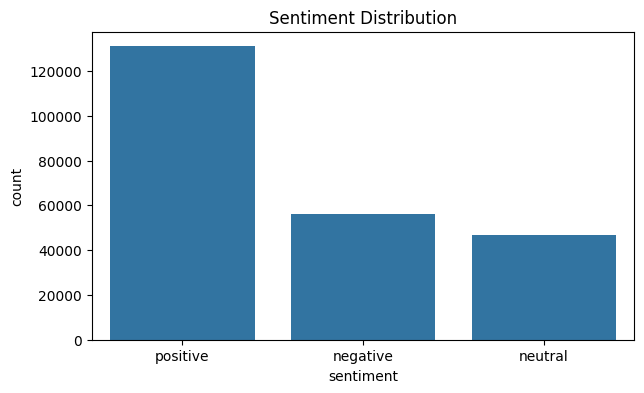

In [27]:
plt.figure(figsize=(7,4))
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()


# 🤖 Predict Function (For Deployment)

In [28]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vec = tfidf.transform([cleaned])
    return model.predict(vec)[0]

predict_sentiment("The product quality is amazing!")


'positive'

# ⚙️Sentiment Function Examples (For Deployment)

In [33]:
print("SENTIMENT USES EXAMPLE")
print("------------------------------")
print(f"The product quality is amazing!  :",predict_sentiment("The product quality is amazing!"))
print(f"Worst experience ever, I totally regret buying this  :",predict_sentiment("Worst experience ever, I totally regret buying this."))
print(f"It's okay, not too good and not too bad  :",predict_sentiment("It's okay, not too good and not too bad."))
print(f"I love how fast the delivery was, very satisfied!  :",predict_sentiment("I love how fast the delivery was, very satisfied!"))
print(f"The item arrived damaged and the support team was unhelpful.  :",predict_sentiment("The item arrived damaged and the support team was unhelpful."))


SENTIMENT USES EXAMPLE
------------------------------
The product quality is amazing!  : positive
Worst experience ever, I totally regret buying this  : negative
It's okay, not too good and not too bad  : positive
I love how fast the delivery was, very satisfied!  : positive
The item arrived damaged and the support team was unhelpful.  : neutral


# 🎨 Sentiment Distribution (Pie Chart + Bar Plot)

C:\Users\pc\AppData\Local\Temp\ipykernel_13100\933500968.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment',


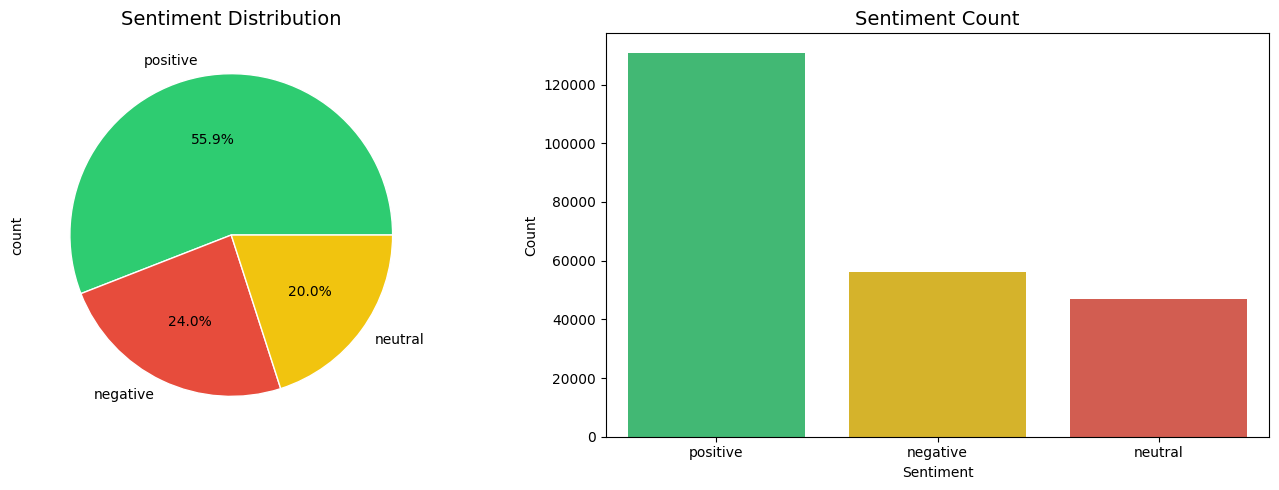

In [34]:
plt.figure(figsize=(14,5))

# Pie chart
plt.subplot(1,2,1)
df['sentiment'].value_counts().plot.pie(
    autopct="%1.1f%%",
    colors=['#2ecc71','#e74c3c','#f1c40f'],
    wedgeprops={'linewidth':1,'edgecolor':'white'}
)
plt.title("Sentiment Distribution", fontsize=14)

# Bar plot
plt.subplot(1,2,2)
sns.countplot(data=df, x='sentiment',
              palette=['#2ecc71','#f1c40f','#e74c3c'])
plt.title("Sentiment Count", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


# 🎨 Emotion Distribution (Professional Bar Plot)

C:\Users\pc\AppData\Local\Temp\ipykernel_13100\832727965.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='emotion', palette='coolwarm')


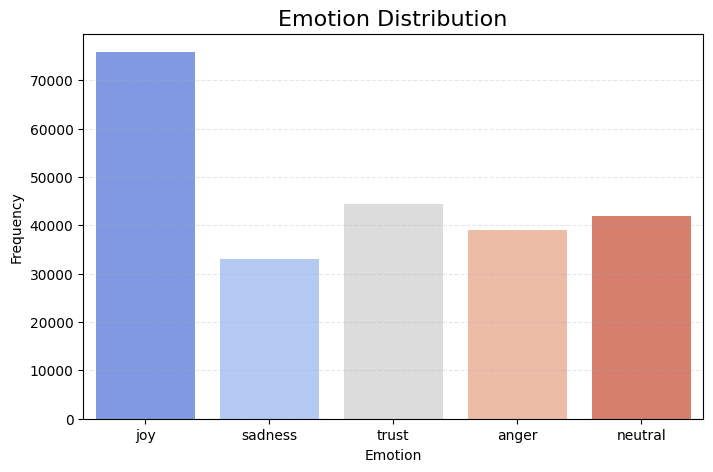

In [35]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='emotion', palette='coolwarm')
plt.title("Emotion Distribution", fontsize=16)
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


# 🎨 WordClouds — Positive vs Negative

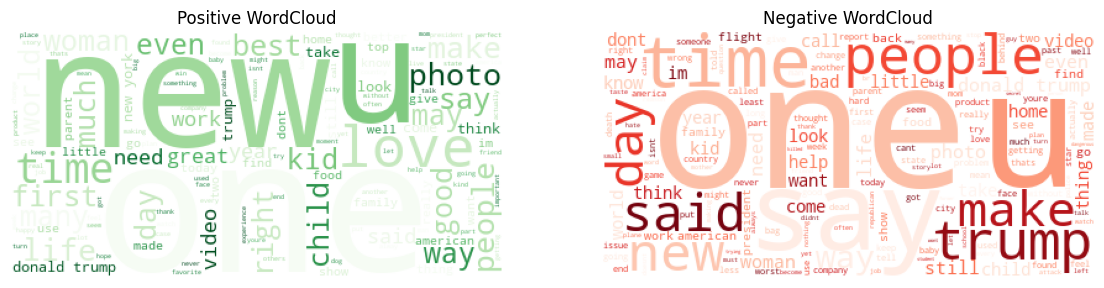

In [36]:
positive_words = " ".join(df[df['sentiment']=='positive']['clean'])
negative_words = " ".join(df[df['sentiment']=='negative']['clean'])

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
wordcloud_pos = WordCloud(background_color='white', colormap='Greens').generate(positive_words)
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.title("Positive WordCloud")

plt.subplot(1,2,2)
wordcloud_neg = WordCloud(background_color='white', colormap='Reds').generate(negative_words)
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.title("Negative WordCloud")

plt.show()


# 💾 Save All Models (Logistic Regression + TF-IDF)

In [37]:
import pickle

# -----------------------------------------------------------
# SAVE TRAINED MODELS
# -----------------------------------------------------------

# Save Logistic Regression Model
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save TF-IDF Vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("All models saved successfully!")


All models saved successfully!


# 👨‍💻 Developed By

#  -- Ayush
- 📧 bhanuseenu914@gmail.com
- 🔗 LinkedIn: https://linkedin.com/in/ayush130
- 🔗 GitHub: https://github.com/ayush13-0